# Machine Learning Course: Text Recognition

Загружаем в рабочую область памяти ВСЕ необходимые для работы внешние бибилиотеки.

> ⚠ **Важно** - на это требуется некоторое время.

Устанавливем дополнительные библиотеки:
* OpenCV - для работы с изображением (чтение файлов изображений, кроп, выделение контуров)
* idx2numpy - работа с датасетами в формате idx

In [ ]:
pip install opencv-python idx2numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.


Открываем рабочие програмные модули, создаем краткие обозначения. Из загруженных библиотек извлекаем только необходимые нам функции

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from IPython.display import display
import idx2numpy
import gzip
import numpy as np
import time

"Читаем рукопись", убираем все оттенки серого, корректируем

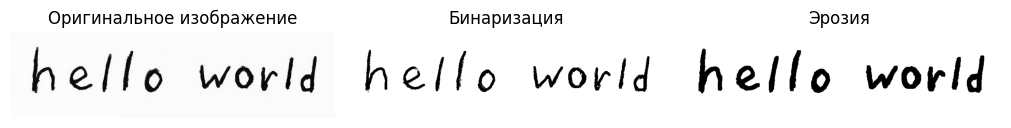

In [2]:
# Открываем изображение
img = cv2.imread("text-hand.png")

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(10, 3))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_axis_off()
axs[0].set_title("Оригинальное изображение")

# Переводим картинку в ч/б (и так была ч/б)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Бинаризация изображения с помощью метода пороговой обработки
ret, img_thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

axs[1].imshow(cv2.cvtColor(img_thresh, cv2.COLOR_BGR2RGB))
axs[1].set_axis_off()
axs[1].set_title("Бинаризация")

# Эрозия на бинарном изображении
img_erode = cv2.erode(img_thresh, np.ones((3, 3), np.uint8), iterations=2)

axs[2].imshow(cv2.cvtColor(img_erode, cv2.COLOR_BGR2RGB))
axs[2].set_axis_off()
axs[2].set_title("Эрозия")

plt.show()

В любом языке текст состоит из отдельных букв. «Разобьем» надпись на отдельные буквы и затем выделием контуры.

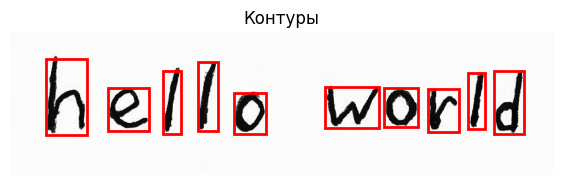

In [3]:
# Нахождение контуров
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Для каждого контура рисуем его bounding box
for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    if hierarchy[0][idx][3] == 0:  # Если контур не имеет родительских контуров
        # Рисуем прямоугольник в виде бокса
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # Данный алгоритм отбрасывает те контуры, которые располагаются внутри других контуров
    # (мы полагаем, что это запчасти от букв)

ax.set_axis_off()
ax.set_title("Контуры")
plt.show()

Теперь, когда мы поэкспериментировали и убедились, что нащ код работает, оформляем его профессионально, в единый программный блок - функцию с имененем def letter_extract(). В текст функции добавляем необходимые действия: увеличиваем контур с буквами в размере, проверяем вложенность контуров,

In [4]:
def letters_extract(image_file: str, out_size=28):
    # Чтение изображения
    img = cv2.imread(image_file)

    # Преобразование изображения в градации серого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Бинаризация изображения
    ret, thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
    # Эрозия изображения для улучшения контуров
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)

    # Получение контуров
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    output = img.copy()

    # Список для сохранения букв
    letters = []

    # Перебираем контуры
    for idx, contour in enumerate(contours):
        # Получение ограничивающего прямоугольника для контура
        (x, y, w, h) = cv2.boundingRect(contour)

        # Проверка, что контур не вложен в другой контур
        if hierarchy[0][idx][3] == 0:
            # Вырезаем букву
            letter_crop = gray[y:y + h, x:x + w]

            # Приведение буквы к квадрату
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)

            if w > h:
                # Увеличение изображения по вертикали
                y_pos = size_max // 2 - h // 2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                # Увеличение изображения по горизонтали
                x_pos = size_max // 2 - w // 2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            # Изменение размера буквы и добавление в список
            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))

    # Сортировка букв по координате X (чтобы располагать их слева направо)
    letters.sort(key=lambda x: x[0], reverse=False)

    return letters

letters=letters_extract('text-hand.png')
display(Image.fromarray(letters[0][2]))
display(Image.fromarray(letters[1][2]))
display(Image.fromarray(letters[2][2]))
display(Image.fromarray(letters[3][2]))
display(Image.fromarray(letters[4][2]))
display(Image.fromarray(letters[5][2]))

Загружаем библиотеки, неообходимые для обучения нейронной сети: *tensorflow, keras*

Если возникает проблема с NumPy, переустановите его, указав другую версию:

```bash
pip uninstall numpy
pip install "numpy<2.0
```

In [6]:
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.constraints import max_norm
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold

Создаем модель EMNIST. Описываем все слои модели.

In [7]:
# EMNIST (Extended MNIST)
def emnist_model():
    # Инициализация модели
    model = Sequential()

    # Первый сверточный слой с 32 фильтрами, размером ядра (3, 3), активация ReLU
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='valid', input_shape=(28, 28, 1), activation='relu'))

    # Второй сверточный слой с 64 фильтрами, активация ReLU
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))

    # Слой подвыборки (MaxPooling) с размером окна (2, 2)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Слой Dropout для предотвращения переобучения (25% нейронов отключаются случайным образом)
    model.add(Dropout(0.25))

    # Преобразование двумерных данных в одномерный вектор
    model.add(Flatten())

    # Полносвязный слой с 512 нейронами, активация ReLU
    model.add(Dense(512, activation='relu'))

    # Слой Dropout для предотвращения переобучения (50% нейронов отключаются случайным образом)
    model.add(Dropout(0.5))

    # Выходной полносвязный слой, количество нейронов соответствует числу классов (emnist_labels), активация softmax
    model.add(Dense(len(emnist_labels), activation='softmax'))

    # Компиляция модели с функцией потерь 'categorical_crossentropy', оптимизатором 'adadelta' и метрикой 'accuracy'
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model


> ⚠ **Важно** - тут может потребоваться изменить путь к датасету (в зависимости от того, в какой среде вы запускаете и где разместили файлы датасета)

In [8]:
# Путь к набору данных EMNIST
emnist_path = 'dataset/'

# Функция для исправления поворота и зеркального отображения
def correct_image_orientation(images):
    corrected_images = []
    for img in images:
        # Поворот изображения на 90 градусов против часовой стрелки
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        # Отзеркаливание по вертикали
        corrected_img = cv2.flip(rotated_img, 0)
        # Инверсия цветов (фон становится белым, а текст — чёрным)
        inverted_img = 255 - corrected_img
        corrected_images.append(inverted_img)
    return np.array(corrected_images)

# Загрузка тренировочных изображений и меток с использованием idx2numpy
with gzip.open(emnist_path + 'emnist-byclass-train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = idx2numpy.convert_from_file(f)
with gzip.open(emnist_path + 'emnist-byclass-train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = idx2numpy.convert_from_file(f)

# Загрузка тестовых изображений и меток
with gzip.open(emnist_path + 'emnist-byclass-test-images-idx3-ubyte.gz', 'rb') as f:
    X_test = idx2numpy.convert_from_file(f)
with gzip.open(emnist_path + 'emnist-byclass-test-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = idx2numpy.convert_from_file(f)

# Применение исправлений к тренировочным и тестовым изображениям
X_train = correct_image_orientation(X_train)
X_test = correct_image_orientation(X_test)

# Преобразование изображений в форму (количество, 28, 28, 1) для использования в модели
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

# Чтение файла и создание отображения индексов на символы
emnist_labels = {}
with open(emnist_path + 'emnist-byclass-mapping.txt', 'r') as f:
    for line in f:
        index, ascii_code = line.split()
        emnist_labels[int(index)] = chr(int(ascii_code))  # Преобразование ASCII-кода в символ

# Проверка размеров данных
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(emnist_labels))

# Уменьшение размера набора данных для ускорения обучения (в 5 раз)
# k = 5
k = 3
X_train = X_train[:X_train.shape[0] // k]
y_train = y_train[:y_train.shape[0] // k]
X_test = X_test[:X_test.shape[0] // k]
y_test = y_test[:y_test.shape[0] // k]

# Нормализация изображений к диапазону [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Преобразование меток в категориальный формат (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, len(emnist_labels))
y_test_cat = keras.utils.to_categorical(y_test, len(emnist_labels))

# Вывод данных после преобразований для проверки
print(f"Тренировочные данные: {X_train.shape}, Метки: {y_train_cat.shape}")
print(f"Тестовые данные: {X_test.shape}, Метки: {y_test_cat.shape}")

(697932, 28, 28, 1) (697932,) (116323, 28, 28, 1) (116323,) 62
Тренировочные данные: (232644, 28, 28, 1), Метки: (232644, 62)
Тестовые данные: (38774, 28, 28, 1), Метки: (38774, 62)


Посмотрите внимательно на результаты вывода. Там даны размеры тренировчной выборки и тестовых данных

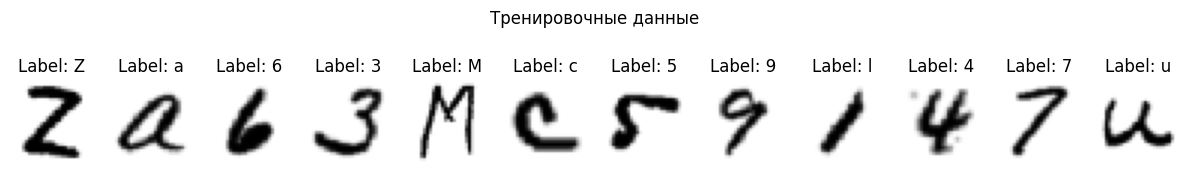

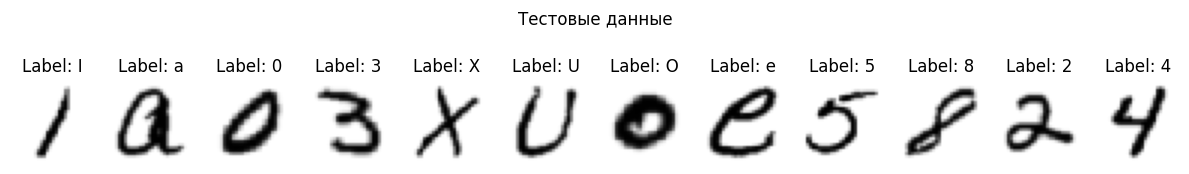

In [9]:
def plot_samples_with_ax(X_data, y_data, title, emnist_labels, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(12, 2))

    for i in range(num_samples):
        # Отображаем изображение на соответствующем ax
        axs[i].imshow(X_data[i].reshape(28, 28), cmap='gray')
        # Устанавливаем заголовок для каждого изображения
        axs[i].set_title(f"Label: {emnist_labels[np.argmax(y_data[i])]}")
        # Отключаем оси
        axs[i].axis('off')

    # Устанавливаем заголовок для всей фигуры
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

# Отображаем 12 тренировочных изображений
plot_samples_with_ax(X_train, y_train_cat, "Тренировочные данные", emnist_labels, num_samples=12)

# Отображаем 12 тестовых изображений
plot_samples_with_ax(X_test, y_test_cat, "Тестовые данные", emnist_labels, num_samples=12)

А теперь - обучаем модель на данных учебного набора данных (dataset). Это долго! Можно пойти приготовить себе сложный ужин - плов или ризотто. И это не шутка. Обучение нейронной сети - не быстрое дело.

In [10]:
# Определение модели
model = emnist_model()

# Добавляем чекпоинты для сохранения лучших весов
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Запуск таймера перед началом обучения
start_time = time.time()

# Обучение модели
history = model.fit(
    X_train, y_train_cat,                 # Тренировочные данные и метки
    batch_size=128,                       # Размер батча
    epochs=50,                            # Количество эпох
    validation_data=(X_test, y_test_cat), # Валидационные данные
    callbacks=[checkpoint],               # Используем чекпоинты
    verbose=1                             # Отображение процесса обучения
)

# Остановка таймера после обучения
end_time = time.time()
training_duration = end_time - start_time

# Вывод времени обучения
print(f'Время обучения: {training_duration:.2f} секунд')

# Загрузка лучших весов после обучения
model.load_weights('best_model.keras')

# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=2)
print(f'Точность на тестовых данных: {test_acc * 100:.2f}%')

Epoch 1/50
1818/1818 [==============================] - ETA: 0s - loss: 3.8482 - accuracy: 0.0582
Epoch 1: val_accuracy improved from -inf to 0.17246, saving model to best_model.keras
1818/1818 [==============================] - 37s 5ms/step - loss: 3.8482 - accuracy: 0.0582 - val_loss: 3.6407 - val_accuracy: 0.1725
Epoch 2/50
1818/1818 [==============================] - ETA: 0s - loss: 3.6710 - accuracy: 0.0929
Epoch 2: val_accuracy improved from 0.17246 to 0.30513, saving model to best_model.keras
1818/1818 [==============================] - 10s 5ms/step - loss: 3.6710 - accuracy: 0.0929 - val_loss: 3.5241 - val_accuracy: 0.3051
Epoch 3/50
1817/1818 [============================>.] - ETA: 0s - loss: 3.5612 - accuracy: 0.1424
Epoch 3: val_accuracy improved from 0.30513 to 0.36380, saving model to best_model.keras
1818/1818 [==============================] - 10s 5ms/step - loss: 3.5612 - accuracy: 0.1425 - val_loss: 3.3742 - val_accuracy: 0.3638
Epoch 4/50
1815/1818 [==================

Ниже реализована кросс-валидация с использованием метода KFold. Данные разбиваются на несколько фолдов, и для каждого фолда модель обучается и оценивается на выделенной части данных, отведенной под валидацию. Этот процесс повторяется для всех фолдов, чтобы проверить стабильность модели на разных подмножествах данных. В итоге рассчитывается средняя точность, что дает оценку производительности модели на всей выборке.

In [11]:
# Количество фолдов для кросс-валидации
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)

# Списки для сохранения результатов
fold_accuracies = []

# Обучение модели с использованием кросс-валидации
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_cat)):
    print(f"Обучение на фолде {fold_idx + 1}/{n_folds}")

    # Создаем модель для каждого фолда
    model = emnist_model()

    # Получаем данные для текущего фолда
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_cat[train_idx], y_train_cat[val_idx]

    # Обучение модели на текущем фолде
    history = model.fit(
        X_train_fold, y_train_fold,                # Тренировочные данные для текущего фолда
        batch_size=128,                            # Размер батча
        epochs=50,                                 # Количество эпох
        validation_data=(X_val_fold, y_val_fold),  # Валидационные данные для текущего фолда
        verbose=1                                  # Отображение процесса обучения
    )

    # Оценка модели на валидационных данных текущего фолда
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Точность на фолде {fold_idx + 1}: {val_acc * 100:.2f}%")

# Средняя точность по всем фолдам
mean_accuracy = np.mean(fold_accuracies)
print(f'Средняя точность по {n_folds} фолдам: {mean_accuracy * 100:.2f}%')

Обучение на фолде 1/5
Epoch 1/50
1455/1455 [==============================] - 8s 5ms/step - loss: 3.8707 - accuracy: 0.0590 - val_loss: 3.6668 - val_accuracy: 0.2069
Epoch 2/50
1455/1455 [==============================] - 8s 5ms/step - loss: 3.6848 - accuracy: 0.0877 - val_loss: 3.5504 - val_accuracy: 0.2871
Epoch 3/50
1455/1455 [==============================] - 7s 5ms/step - loss: 3.5863 - accuracy: 0.1309 - val_loss: 3.4261 - val_accuracy: 0.3215
Epoch 4/50
1455/1455 [==============================] - 7s 5ms/step - loss: 3.4665 - accuracy: 0.1815 - val_loss: 3.2706 - val_accuracy: 0.3776
Epoch 5/50
1455/1455 [==============================] - 7s 5ms/step - loss: 3.3198 - accuracy: 0.2362 - val_loss: 3.0879 - val_accuracy: 0.3975
Epoch 6/50
1455/1455 [==============================] - 7s 5ms/step - loss: 3.1543 - accuracy: 0.2855 - val_loss: 2.8868 - val_accuracy: 0.4227
Epoch 7/50
1455/1455 [==============================] - 7s 5ms/step - loss: 2.9818 - accuracy: 0.3274 - val_loss: 

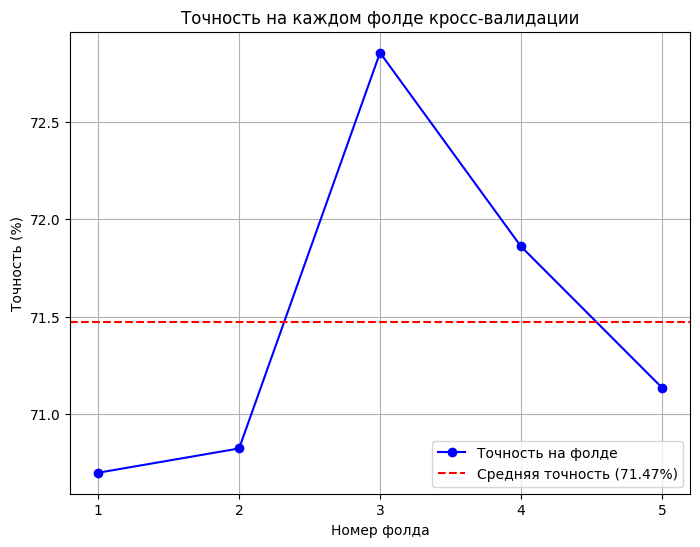

In [12]:
# Построение графика точности на каждом фолде
plt.figure(figsize=(8, 6))
folds = np.arange(1, len(fold_accuracies) + 1)

# Вывод точности для каждого фолда
plt.plot(folds, np.array(fold_accuracies) * 100, marker='o', linestyle='-', color='b', label='Точность на фолде')

# Вывод средней точности
plt.axhline(y=np.mean(fold_accuracies) * 100, color='r', linestyle='--', label=f'Средняя точность ({np.mean(fold_accuracies) * 100:.2f}%)')

# Настройка подписей
plt.title('Точность на каждом фолде кросс-валидации')
plt.xlabel('Номер фолда')
plt.ylabel('Точность (%)')
plt.xticks(folds)
plt.legend(loc='lower right')
plt.grid(True)

# Отображение графика
plt.show()

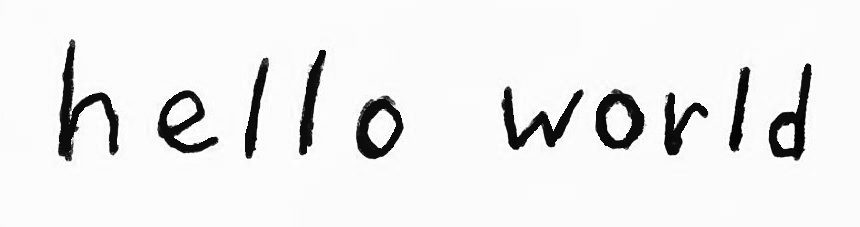

1/1 [==============================] - 0s 17ms/step
Распознанный текст: h8110W0r1d


In [13]:
def recognize_text(image_file):
    # Извлекаем буквы с изображения
    letters = letters_extract(image_file)

    recognized_text = []

    # Пройдем по каждому фрагменту с буквой
    for _, _, letter in letters:
        # Преобразуем букву в формат, который принимает модель
        letter = letter.reshape(1, 28, 28, 1).astype('float32') / 255.0

        # Предсказываем класс с помощью обученной модели
        prediction = model.predict(letter)

        # Определяем индекс класса с наибольшей вероятностью
        predicted_label_index = np.argmax(prediction)

        # Получаем символ, используя наш словарь emnist_labels
        recognized_char = emnist_labels[predicted_label_index]
        recognized_text.append(recognized_char)

    # Соединяем буквы в строку и возвращаем результат
    return ''.join(recognized_text)

display(Image.fromarray(cv2.imread("text-hand.png")))
result_text = recognize_text("text-hand.png")
print(f"Распознанный текст: {result_text}")